In [6]:
#If the distribution skewness of one feature is more than 0.5, do log_transform.
# Imports
import numpy as np
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import skew
import matplotlib.pyplot as plt


import seaborn as sns

import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

from xgboost import XGBRegressor

In [7]:
train_data=pd.read_csv('input/train.csv');
test_data=pd.read_csv('input/test.csv')
print('shape of train_data'+ str(train_data.shape) + 'shape of test_data'+ str(test_data.shape) );

shape of train_data(1460, 81)shape of test_data(1459, 80)


In [8]:
#Check repeats
num_uniques= len( train_data['Id'].unique() )
print('There are '+ str(train_data.shape[0]- num_uniques)+ ' repeats in train_data');
num_uniques= len( test_data['Id'].unique() )
print('There are '+ str(test_data.shape[0]- num_uniques)+ ' repeats in test_data');
#Drop the Id column


There are 0 repeats in train_data
There are 0 repeats in test_data


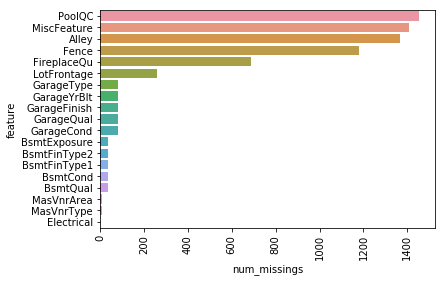

              num_missings       feature
PoolQC                1453        PoolQC
MiscFeature           1406   MiscFeature
Alley                 1369         Alley
Fence                 1179         Fence
FireplaceQu            690   FireplaceQu
LotFrontage            259   LotFrontage
GarageType              81    GarageType
GarageYrBlt             81   GarageYrBlt
GarageFinish            81  GarageFinish
GarageQual              81    GarageQual
GarageCond              81    GarageCond
BsmtExposure            38  BsmtExposure
BsmtFinType2            38  BsmtFinType2
BsmtFinType1            37  BsmtFinType1
BsmtCond                37      BsmtCond
BsmtQual                37      BsmtQual
MasVnrArea               8    MasVnrArea
MasVnrType               8    MasVnrType
Electrical               1    Electrical


In [9]:
#Check missing Data in train_data.
missing=pd.DataFrame();
missing['num_missings']= train_data.isnull().sum();
missing= missing[ missing['num_missings']>0 ];
missing.sort_values('num_missings', ascending=False, inplace=True);
missing['feature']= missing.index;
sns.barplot(data= missing, y='feature', x='num_missings', orient='h')
plt.xticks(rotation=90)
plt.show()
print(missing)



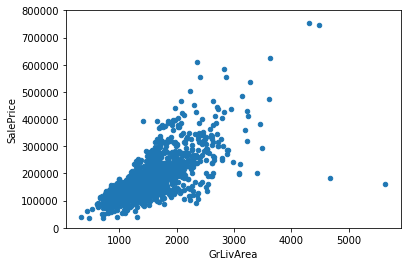

the shape of train_data is(1456, 81)


In [10]:
#Find and delete outliers
#bivariate analysis:saleprice as a function of grlivarea
variable = 'GrLivArea'
data_scatter = pd.concat([train_data['SalePrice'], train_data[variable] ], axis=1)
data_scatter.plot.scatter( x=variable, y='SalePrice', ylim=(0,800000) );
plt.show()

#Delete all 4 houses whose GrLivArea is more than 4000

train_data= train_data.drop( train_data[ train_data['GrLivArea']>4000].index, axis=0 );
print('the shape of train_data is'+ str(train_data.shape ) );

In [11]:
#Concatenate train_data and test_data
train_y= train_data.SalePrice;
train_data= train_data.drop( ['Id', 'SalePrice'], axis=1);

test_Id= test_data['Id'];
test_data= test_data.drop('Id', axis=1);

all_data= pd.concat( [train_data, test_data], axis=0);
print('the shape of train_data is'+ str(train_data.shape ) );
print('the shape of test_data is'+ str(test_data.shape ) );
print('the shape of all_data is'+ str(all_data.shape ) );

the shape of train_data is(1456, 79)
the shape of test_data is(1459, 79)
the shape of all_data is(2915, 79)


In [12]:
#Fill in the NA in train_data whose meaning is clear in the data description.
all_data[ 'PoolQC' ]=all_data[ 'PoolQC' ].fillna('No');
all_data[ 'MiscFeature' ]=all_data[ 'MiscFeature' ].fillna('No');
all_data[ 'Alley' ]=all_data[ 'Alley' ].fillna('No');
all_data[ 'Fence' ]=all_data[ 'Fence' ].fillna('No');
all_data[ 'FireplaceQu']=all_data[ 'FireplaceQu' ].fillna('No');
all_data[ 'LotFrontage' ]=all_data[ 'LotFrontage' ].fillna(0);
all_data[ 'GarageType' ]=all_data[ 'GarageType' ].fillna('No');
all_data[ 'GarageFinish' ]=all_data[ 'GarageFinish'].fillna('No');
all_data[ 'GarageQual'] =all_data[ 'GarageQual' ].fillna('No');
all_data[ 'GarageCond'] =all_data[ 'GarageCond' ].fillna('No');
all_data[ 'BsmtExposure' ]=all_data[ 'BsmtExposure' ].fillna('No');
all_data[ 'BsmtFinType2' ]=all_data[ 'BsmtFinType2' ].fillna('No');
all_data[ 'BsmtCond'] =all_data[ 'BsmtCond'].fillna('No');
all_data[ 'BsmtFinType1' ]=all_data[ 'BsmtFinType1'].fillna('No');
all_data[ 'BsmtQual' ]=all_data[ 'BsmtQual'].fillna('No');
all_data[ 'MasVnrArea' ]=all_data[ 'MasVnrArea' ].fillna(0);
all_data[ 'MasVnrType' ]=all_data[ 'MasVnrType' ].fillna('None');
all_data.loc[ all_data['GarageYrBlt'].isnull(), 'GarageYrBlt']= all_data.loc[ all_data['GarageYrBlt'].isnull(), 'YearBuilt'].values;


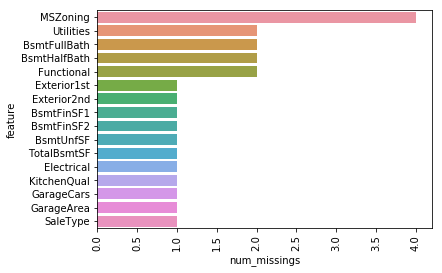

              num_missings       feature
MSZoning                 4      MSZoning
Utilities                2     Utilities
BsmtFullBath             2  BsmtFullBath
BsmtHalfBath             2  BsmtHalfBath
Functional               2    Functional
Exterior1st              1   Exterior1st
Exterior2nd              1   Exterior2nd
BsmtFinSF1               1    BsmtFinSF1
BsmtFinSF2               1    BsmtFinSF2
BsmtUnfSF                1     BsmtUnfSF
TotalBsmtSF              1   TotalBsmtSF
Electrical               1    Electrical
KitchenQual              1   KitchenQual
GarageCars               1    GarageCars
GarageArea               1    GarageArea
SaleType                 1      SaleType


In [13]:
#Check left NA in all_data (all NAs in train is filt).
missing=pd.DataFrame();
missing['num_missings']= all_data.isnull().sum();
missing= missing[ missing['num_missings']>0 ];
missing.sort_values('num_missings', ascending=False, inplace=True);
missing['feature']= missing.index;
sns.barplot(data= missing, y='feature', x='num_missings', orient='h')
plt.xticks(rotation=90)
plt.show()
print(missing)
#Since the left NAs are few, I will just fill in with mean or most-frequent.

In [14]:
train_data_fill= all_data[ : train_data.shape[0]].copy();    #iloc, loc and []
test_data_fill= all_data[ train_data.shape[0]: ].copy();     #[] return a copy? loc return not a copy?


#Fill in missing data in test_data with most frequent values of train_data for categorical columns and mean of train_data for numeric columns.
quantitative=[col for col in train_data.columns if train_data[col].dtype != 'object'];
qualitative=[col for col in train_data.columns if train_data[col].dtype == 'object'];



for col in quantitative:
    if all_data[col].isnull().any():
        col_mean= np.mean( train_data_fill[col].drop( train_data_fill[train_data_fill[col].isnull() ].index ) );
        train_data_fill[col]= train_data_fill[col].fillna(col_mean).values;
        test_data_fill[col] =test_data_fill[col].fillna(col_mean).values;
        all_data[col] =all_data[col].fillna(col_mean).values;
    
for col in qualitative:
    col_most_frequent=pd.DataFrame();
    col_most_frequent['value']= train_data_fill[col].unique();
    frequency=[];
    for cat in col_most_frequent['value']:
        frequency.append( train_data_fill[ train_data_fill[col]==cat ].shape[0] );
    col_most_frequent['frequency']=frequency;
    
    col_most_frequent= col_most_frequent.sort_values('frequency', ascending=False);
    most_frequent=col_most_frequent.iloc[0].loc['value'];    
    train_data_fill[col]= train_data_fill[col].fillna( most_frequent).values;
    test_data_fill[col] =test_data_fill[ col].fillna( most_frequent ).values;
    all_data[col] =all_data[col].fillna(most_frequent).values;

    


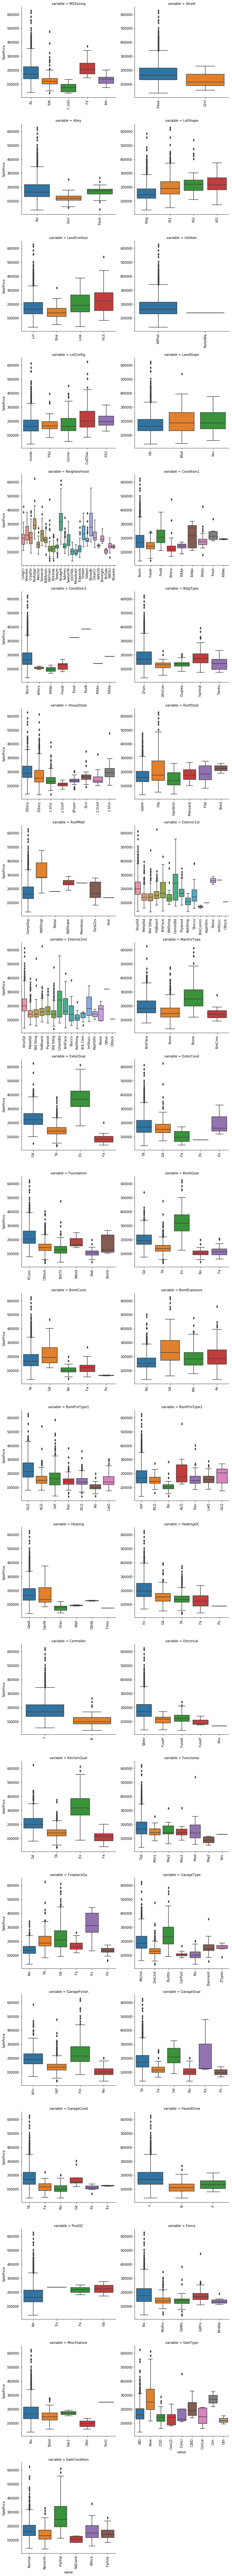

In [12]:
def boxplot(x,y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90);
    
train_melted= pd.melt( pd.concat( [train_y, train_data_fill], axis=1), id_vars=['SalePrice'], value_vars= qualitative );
train_Facet= sns.FacetGrid(train_melted, col='variable',  col_wrap=2, sharex=False, sharey=False, height=5);
train_plot= train_Facet.map(boxplot, 'value', 'SalePrice')
plt.show()


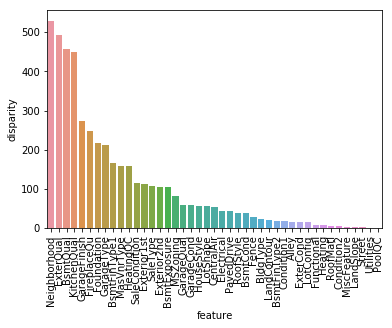

          feature   disparity
8    Neighborhood  529.104028
18      ExterQual  493.061833
21       BsmtQual  457.705115
30    KitchenQual  448.335263
34   GarageFinish  272.230667
32    FireplaceQu  247.148772
20     Foundation  215.783497
33     GarageType  211.432772
24   BsmtFinType1  165.085815
17     MasVnrType  158.800444
27      HeatingQC  158.725487
42  SaleCondition  114.376032
15    Exterior1st  113.158795
41       SaleType  107.126659
16    Exterior2nd  103.729606
23   BsmtExposure  103.309503
0        MSZoning   82.690073
35     GarageQual   59.180314
36     GarageCond   59.037780
12     HouseStyle   55.774937
3        LotShape   55.408240
28     CentralAir   52.622009
29     Electrical   43.102528
37     PavedDrive   42.830655
13      RoofStyle   38.714296
22       BsmtCond   37.027631
39          Fence   27.693339
11       BldgType   23.234979
4     LandContour   19.078049
25   BsmtFinType2   17.622256
9      Condition1   17.264183
2           Alley   15.641579
19      Ex

In [15]:
#Present the disparity: diversity of partition.
def ANOVA(DF):
    anova=pd.DataFrame();
    anova['feature']= qualitative;
    pvals=[];
    for col in qualitative:
        values=[];
        for value in DF[col].unique():
            values.append( train_y[ DF[col]==value ].values );
        pvals.append( stats.f_oneway(*values)[1] )
        
    anova['disparity']= np.log(1/np.array( pvals) );
    anova= anova.sort_values('disparity', ascending= False);
    return anova

train_disparity= ANOVA(train_data_fill);
sns.barplot(data= train_disparity, x='feature', y='disparity');
plt.xticks(rotation=90)
plt.show()
   
print(train_disparity)        

In [16]:
#Get dummies for high disparity categorical features.
cat_high_disparity=list( train_disparity[train_disparity['disparity']>100 ]['feature'].values );
all_high_disparity=all_data[ cat_high_disparity].copy();
all_data=all_data.drop( cat_high_disparity, axis=1);

all_high_disparity=pd.get_dummies(all_high_disparity);
all_data=pd.concat([all_data, all_high_disparity], axis=1);
qualitative_left=[col for col in qualitative if col not in cat_high_disparity];

print(qualitative_left);

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature']


In [15]:
print(cat_high_disparity)

['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'FireplaceQu', 'Foundation', 'GarageType', 'BsmtFinType1', 'MasVnrType', 'HeatingQC', 'SaleCondition', 'Exterior1st', 'SaleType', 'Exterior2nd', 'BsmtExposure']


In [17]:
#Encode the categorical columns with numbers according to the mean SalePrice.
cat_encoded=[];
for col in qualitative_left:
    cat2num=pd.DataFrame();
    cat2num['cat']=train_data_fill[col].unique();
    cat2num.index= cat2num['cat'].values;
    spmeans=[];
    
    for cat in cat2num['cat'].values:
        spmeans.append( np.mean( train_y[ train_data_fill[col]== cat ].values ) )
    cat2num['spmean']=spmeans;
    cat2num= cat2num.sort_values(by='spmean');
    cat2num['num']=np.arange(1, cat2num.shape[0]+1 ,1);

    cat2num_dict= cat2num['num'].to_dict();
    
    for cat, num in cat2num_dict.items():
        train_data_fill.loc[train_data_fill[col]==cat, col+'_E'] = num;   #If some categorical values in test-data is not replaced, keep it as NA
        test_data_fill.loc[test_data_fill[col]==cat, col+'_E'] = num;
        all_data.loc[all_data[col]==cat, col+'_E'] = num;
    cat_encoded.append(col+'_E');

train_data_fill=train_data_fill.drop( qualitative_left, axis=1);
test_data_fill=test_data_fill.drop( qualitative_left, axis=1);
all_data=all_data.drop( qualitative_left, axis=1);


In [18]:
#check whether all categorical values are conveted to be numbers
all_data.isnull().sum().sum()

0

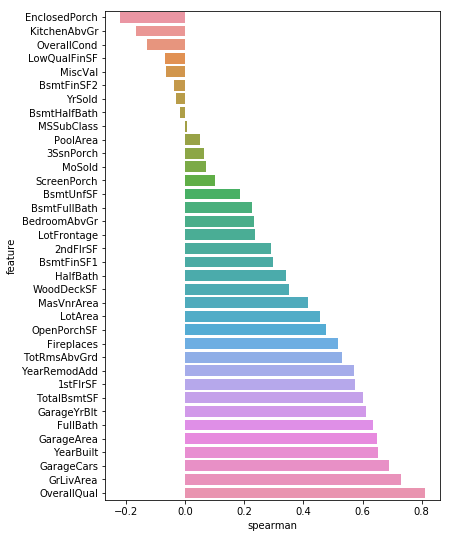

In [19]:
train_data_encoded=all_data[0: train_data.shape[0] ].copy();
test_data_encoded=all_data[train_data.shape[0]: ].copy();

#Calculate the correlation between quantitative features and SalePrice. Pick up these highly correlated quantitative parameters.
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features) ) )
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.show()
    
    spr1=spr.copy();
    spr1["abs_spearman"]= abs(spr['spearman']);
    spr1=spr1.sort_values("abs_spearman", ascending=False);
    
    return list( spr1.loc[ spr1["abs_spearman"]> 0.4,'feature'] )
    
features = quantitative
num_essential= spearman(pd.concat( [train_y, train_data_encoded], axis=1 ), features)


In [20]:
print(num_essential)


['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'GarageArea', 'FullBath', 'GarageYrBlt', 'TotalBsmtSF', '1stFlrSF', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF', 'LotArea', 'MasVnrArea']


In [21]:
#Log transform and square terms
def log_transform(DF, feature):
    DF.loc[:, feature]= np.log1p( DF.loc[:, feature].values );
    
def square_transform(DF, feature):
    DF.loc[:, feature+'_2']= ( DF.loc[:, feature].values )**2;
    
def has_transform(DF, feature):
    DF.loc[:, 'has_'+feature]= DF[feature].apply( lambda x: 1 if x>0 else 0) ;

# Evaluation Function;
#def N_RMSE(prediction, target, **kwargs):
#    prediction=np.array(prediction);
#    target=np.array(target);
#    return -np.sqrt( np.mean( (prediction- target)**2 ) );
#my_scorer= make_scorer(N_RMSE, greater_is_better= True);


skewness=pd.DataFrame();
skewness['feature']=quantitative;
all_quantitative= all_data[quantitative];
skewness['skew']=all_quantitative.apply(lambda x: skew(x) ).values;
skewness=skewness.sort_values('skew', ascending=False);
num_skew=list( skewness[ skewness['skew']>0.5]['feature'] )
for var in num_skew:
    log_transform(all_data, var);


#log_variable=['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LotArea', 'LotFrontage', 'KitchenAbvGr', 'GarageArea'];
#square_variable=[ 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','2ndFlrSF', 'Neighborhood_E', 'RoofMatl_E', 'GrLivArea'];
has_variable=['TotalBsmtSF', 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']
square_var_final=[];
has_var_final=[];

for var in num_essential:
    square_transform(all_data, var);
    square_var_final.append( var+'_2');
    
for var in has_variable:
    has_transform(all_data, var);
    has_var_final.append( 'has_'+var);

all_data['WheNew']= all_data['YearBuilt'].apply(lambda x: 1 if x>1900 else 0);
has_var_final.append('WheNew');



In [22]:
# Standardize numerical features
train_final= all_data[0: train_data.shape[0] ];
train_y_final= np.log(train_y);

test_final= all_data[train_data.shape[0]: ];

#stdSc = StandardScaler()
#standardized=[col for col in quantitative if train_data[col].nunique()>20 ];

#train_final.loc[:, standardized ] = stdSc.fit_transform(train_final.loc[:, standardized] )
#test_final.loc[:, standardized] = stdSc.transform(test_final.loc[:, standardized])
#Notice: we often need to conduct the same transform to both test data and train data.

In [28]:
train_final.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,LotArea_2,MasVnrArea_2,has_TotalBsmtSF,has_GarageArea,has_2ndFlrSF,has_MasVnrArea,has_WoodDeckSF,has_OpenPorchSF,has_PoolArea,WheNew
0,4.110874,65.0,9.042040,7,1.791759,2003,2003,5.283204,6.561031,0.0,...,81.758488,27.912242,1,1,1,1,0,1,0,1
1,3.044522,80.0,9.169623,6,2.197225,1976,1976,0.000000,6.886532,0.0,...,84.081978,0.000000,1,1,0,0,1,0,0,1
2,4.110874,68.0,9.328212,7,1.791759,2001,2002,5.093750,6.188264,0.0,...,87.015545,25.946291,1,1,1,1,0,1,0,1
3,4.262680,60.0,9.164401,7,1.791759,1915,1970,0.000000,5.379897,0.0,...,83.986248,0.000000,1,1,1,0,0,1,0,1
4,4.110874,84.0,9.565284,8,1.791759,2000,2000,5.860786,6.486161,0.0,...,91.494655,34.348815,1,1,1,1,1,1,0,1


In [23]:
#Realize cross-validation with cross_val_score: RMSE of logrithms between predicted and real data.
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_final, train_y_final, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [24]:
#Model 1. Lasso regression, L1 penalty. As a result, for high values of λ, many coefficients are exactly zeroed under lasso, which is never the case in ridge regression.
alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1];
alphas=np.array(alphas);
scores=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha, max_iter=50000)
    scores.append( rmse_cv(lasso).mean() );
    
scores=np.array(scores)
best_alpha= alphas[ scores== min(scores) ][0];
best_score=min(scores);
print('Lasso, best score is '+str(best_score)+ 'best alpha is '+str(best_alpha) );

alphas2=[0.6* best_alpha, 0.8* best_alpha, 1.0* best_alpha, 1.2* best_alpha, 1.4* best_alpha];
alphas2=np.array(alphas2);

scores2=[];
for alpha in alphas2:
    lasso=Lasso(alpha=alpha, max_iter=50000)
    scores2.append( rmse_cv(lasso).mean() );

scores2=np.array(scores2)
best_score2=min(scores2);

best_alpha2= alphas2[ scores2== best_score2 ][0];#think twice.
print('Lasso, best score is '+str(best_score2)+ 'best alpha is '+str(best_alpha2) );
# # Train the model with all training data.
model_lasso=Lasso(alpha= best_alpha2, max_iter=200000);
model_lasso.fit(train_final, train_y_final)

prediction= np.exp( model_lasso.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/lasso_sol_3.csv", index = False)

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

Lasso, best score is 0.11203593629894255best alpha is 0.0006


/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

TypeError: only integer scalar arrays can be converted to a scalar index

Lasso picked 91 features and eliminated the other 122 features


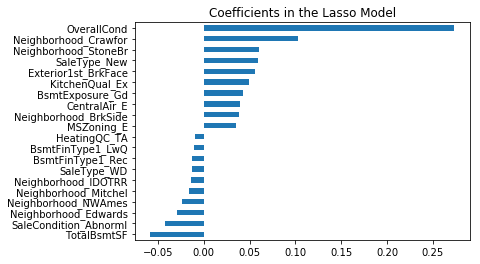

In [35]:
coefs = pd.Series(model_lasso.coef_, index = train_final.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

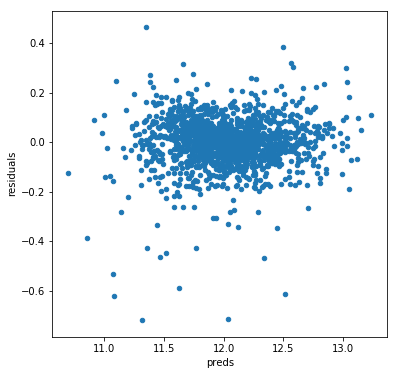

In [38]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(train_final), "true": train_y_final})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [44]:
#Model 2: Ridge regularizaiton.
alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60];
alphas=np.array(alphas);
scores = [rmse_cv(Ridge(alpha = alpha,  max_iter=50000) ).mean() for alpha in alphas]  
scores=np.array(scores)
best_score=min(scores);
best_alpha= alphas[ scores== best_score ][0];
print('Ridge model, best score is '+ str(best_score)+ 'best alpha is '+str(best_alpha) );

alphas2=[0.6* best_alpha, 0.8* best_alpha, 1.0* best_alpha, 1.2* best_alpha, 1.4* best_alpha];
alphas2=np.array(alphas2);

scores2=[rmse_cv(Ridge(alpha = alpha,  max_iter=50000) ).mean() for alpha in alphas2];
scores2=np.array(scores2)
best_score2=min(scores2);
best_alpha2= alphas2[ scores2== best_score2 ][0];#think twice.
print('Ridge, best score is '+str(best_score2)+ 'best alpha is '+str(best_alpha2) );

# Train the model with all training data.
model_ridge=Ridge(alpha= best_alpha2, max_iter=200000);
model_ridge.fit(train_final, train_y_final)

prediction= np.exp( model_ridge.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/ridge_sol_3.csv", index = False)
#Best alpha is 10 in study 4

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.94333e-17): result may not be accurate.
  overwrite_a=True).T
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.18891e-17): result may not be accurate.
  overwrite_a=True).T
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.93348e-17): result may not be accurate.
  overwrite_a=True).T
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.01182e-17): result may not be accurate.
  overwrite_a=True).T
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.12229e-17): result may not be accurate.
  overwrite_a=True).T


Ridge model, best score is 0.11484500836094343best alpha is 10.0
Ridge, best score is 0.11484500836094343best alpha is 10.0


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=200000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge picked 213 features and eliminated the other 0 features


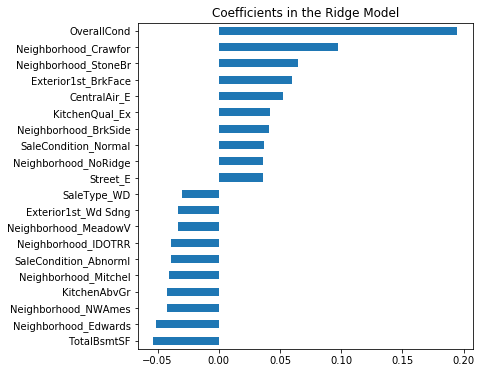

<Figure size 432x432 with 0 Axes>

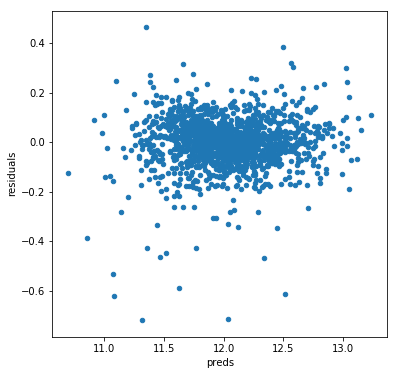

In [46]:
plt.figure();
coefs = pd.Series(model_ridge.coef_, index = train_final.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

plt.figure()
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(train_final), "true": train_y_final})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [ ]:

# Perform Grid-Search to decide the optimal parameters.
from sklearn.model_selection import cross_val_predict, GridSearchCV

gsc = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={
        'learning_rate': (0.005, 0.01, 0.03),
        'n_estimators': (800, 1600, 2400, 3200),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0,   n_jobs=-1)
    
grid_result = gsc.fit(train_final, train_y_final)
best_params = grid_result.best_params_
best_score= np.sqrt( -gsc.best_score_)

In [64]:
#Model3. Use GradientBoostingReressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
n_rounds=[1600, 3200]; #more better
learning_rates=[0.005, 0.01, 0.03];

scores=np.zeros( (len(n_rounds), len(learning_rates) ) );
index_NR=0;
index_LR=0;
best_score= float("inf");
for n_round in n_rounds:
    for learning_rate in learning_rates: 
        model_GBR=GradientBoostingRegressor(n_estimators= n_round, learning_rate=learning_rate);
        scores[ n_rounds.index(n_round), learning_rates.index( learning_rate) ]= rmse_cv(model_GBR).mean();
        if scores[n_rounds.index(n_round), learning_rates.index( learning_rate) ]< best_score:
            index_NR= n_rounds.index(n_round);
            index_LR= learning_rates.index( learning_rate);
            best_score= scores[ index_NR, index_LR ];
            
print('GradientBoostingRegressor, best score is '+str(best_score) +
      ' best n_round is '+str(n_rounds[index_NR] )+ ' best learning rate is '+str(learning_rates[index_LR]) );


model_GBR=GradientBoostingRegressor(loss="ls", criterion="friedman_mse", n_estimators= n_rounds[index_NR], 
                                    learning_rate= learning_rates[index_LR] );
model_GBR.fit( train_final, train_y_final);
prediction= np.exp( model_GBR.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/GBR_sol_3.csv", index = False)

GradientBoostingRegressor, best score is 0.11703119657681867 best n_round is 3200 best learning rate is 0.01


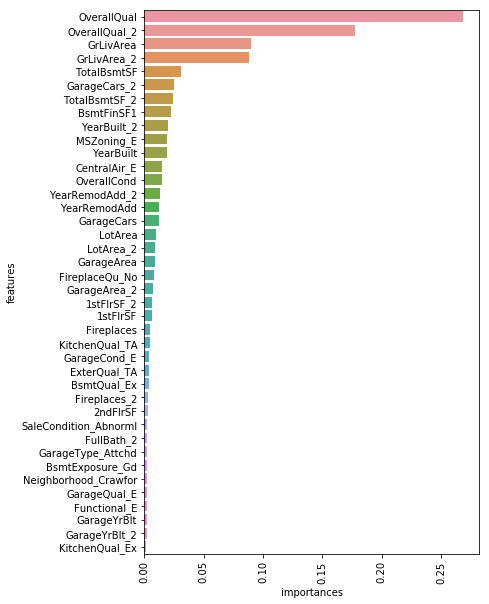

In [76]:
# Get numerical feature importances
feature_imp= pd.DataFrame();
feature_imp["importances"]=model_GBR.feature_importances_;
feature_imp["features"]=train_final.columns;

feature_imp.sort_values('importances', ascending=False, inplace=True);
plt.figure(figsize=(6, 0.25*40 ) )
sns.barplot(data= feature_imp.iloc[0:40, :], y='features', x='importances', orient='h')
plt.xticks(rotation=90)
plt.show()

In [70]:
#model 4: RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV

n_estimators=[400, 800, 1600];
max_depths=[None];

scores=np.zeros( (len(n_estimators), len(max_depths) ) );
index_NE=0;
index_MD=0;
best_score= float("inf");
for n_estimator in n_estimators:
    for max_depth in max_depths: 
        model_RFR=RandomForestRegressor(n_estimators= n_estimator, max_depth=max_depth);
        scores[ n_estimators.index(n_estimator), max_depths.index( max_depth) ]= rmse_cv(model_RFR).mean();
        if scores[n_estimators.index(n_estimator), max_depths.index( max_depth) ]< best_score:
            index_NE= n_estimators.index(n_estimator);
            index_MD= max_depths.index( max_depth);
            best_score= scores[ index_NE, index_MD ];
            
print('RandomForestRegressor, best score is '+str(best_score) +
      ' best n_estimator is '+str(n_estimators[index_NE] )+ ' best max_depth is '+str(max_depths[index_MD]) );


model_RFR=RandomForestRegressor(criterion="mse", n_estimators= n_estimators[index_NE], 
                                    max_depth= max_depths[index_MD] );
model_RFR.fit( train_final, train_y_final);
prediction= np.exp( model_RFR.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/RFR_sol_3.csv", index = False)

RandomForestRegressor, best score is 0.1366517612977651 best n_estimator is 1600 best max_depth is None


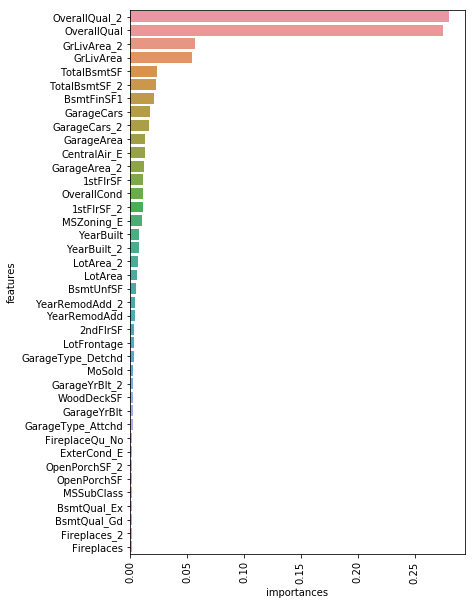

In [74]:
# Get numerical feature importances

# List of tuples with variable and importance
feature_imp= pd.DataFrame();
feature_imp["importances"]=model_RFR.feature_importances_;
feature_imp["features"]=train_final.columns;

feature_imp.sort_values('importances', ascending=False, inplace=True);

plt.figure(figsize=(6, 0.25*40 ) )
sns.barplot(data= feature_imp.iloc[0:40, :], y='features', x='importances', orient='h')
plt.xticks(rotation=90)
plt.show()

#Maybe I shouldn't introduce square terms. 

In [77]:
#Model 5. Use AdaBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor
n_rounds=[1600, 3200]; #more better
learning_rates=[0.01, 0.05, 0.1, 0.5];

scores=np.zeros( (len(n_rounds), len(learning_rates) ) );
index_NR=0;
index_LR=0;
best_score= float("inf");
for n_round in n_rounds:
    for learning_rate in learning_rates: 
        model_Ada=AdaBoostRegressor(n_estimators= n_round, learning_rate=learning_rate);
        scores[ n_rounds.index(n_round), learning_rates.index( learning_rate) ]= rmse_cv(model_Ada).mean();
        if scores[n_rounds.index(n_round), learning_rates.index( learning_rate) ]< best_score:
            index_NR= n_rounds.index(n_round);
            index_LR= learning_rates.index( learning_rate);
            best_score= scores[ index_NR, index_LR ];
            
print('AdaBoostRegressor, best score is '+str(best_score) +
      ' best n_round is '+str(n_rounds[index_NR] )+ ' best learning rate is '+str(learning_rates[index_LR]) );


model_Ada= AdaBoostRegressor( n_estimators= n_rounds[index_NR], 
                                    learning_rate= learning_rates[index_LR] );
model_Ada.fit( train_final, train_y_final);
prediction= np.exp( model_Ada.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/Ada_sol_3.csv", index = False)

AdaBoostRegressor, best score is 0.16616333963333613 best n_round is 3200 best learning rate is 0.5


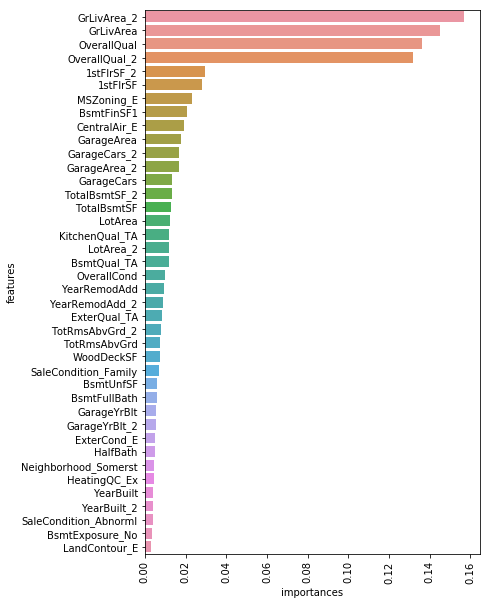

In [78]:
# Get numerical feature importances

# List of tuples with variable and importance
feature_imp= pd.DataFrame();
feature_imp["importances"]=model_Ada.feature_importances_;
feature_imp["features"]=train_final.columns;

feature_imp.sort_values('importances', ascending=False, inplace=True);

plt.figure(figsize=(6, 0.25*40 ) )
sns.barplot(data= feature_imp.iloc[0:40, :], y='features', x='importances', orient='h')
plt.xticks(rotation=90)
plt.show()

#Maybe I shouldn't introduce square terms. 

In [81]:
# model 6: XGBoost

from xgboost import XGBRegressor
n_rounds=[1600, 3200]; #more better
learning_rates=[0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5];

scores=np.zeros( (len(n_rounds), len(learning_rates) ) );
index_NR=0;
index_LR=0;
best_score= float("inf");
for n_round in n_rounds:
    for learning_rate in learning_rates: 
        model_XGB=XGBRegressor(n_estimators= n_round, learning_rate=learning_rate);
        scores[ n_rounds.index(n_round), learning_rates.index( learning_rate) ]= rmse_cv(model_XGB).mean();
        if scores[n_rounds.index(n_round), learning_rates.index( learning_rate) ]< best_score:
            index_NR= n_rounds.index(n_round);
            index_LR= learning_rates.index( learning_rate);
            best_score= scores[ index_NR, index_LR ];
            
print('XGBRegressor, best score is '+str(best_score) +
      ' best n_round is '+str(n_rounds[index_NR] )+ ' best learning rate is '+str(learning_rates[index_LR]) );


model_XGB= XGBRegressor( n_estimators= n_rounds[index_NR], 
                                    learning_rate= learning_rates[index_LR] );
model_XGB.fit( train_final, train_y_final);
prediction= np.exp( model_XGB.predict(test_final) );
solution = pd.DataFrame( {"Id":test_Id, "SalePrice":prediction} )
solution.to_csv("input/XGB_sol_3.csv", index = False)

XGBRegressor, best score is 0.11770143281580703 best n_round is 3200 best learning rate is 0.01


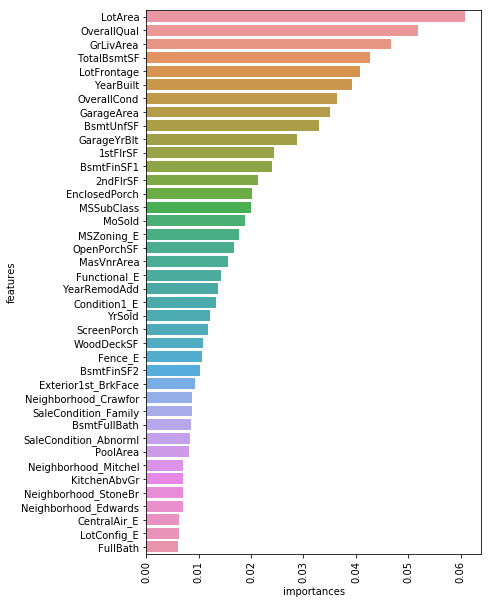

In [82]:
# Get numerical feature importances

feature_imp= pd.DataFrame();
feature_imp["importances"]=model_XGB.feature_importances_;
feature_imp["features"]=train_final.columns;

feature_imp.sort_values('importances', ascending=False, inplace=True);

plt.figure(figsize=(6, 0.25*40 ) )
sns.barplot(data= feature_imp.iloc[0:40, :], y='features', x='importances', orient='h')
plt.xticks(rotation=90)
plt.show()

#Maybe I shouldn't introduce square terms. 

In [80]:
print("The best model is the Lasso model. The RMSE of 5-fold cross validation is 0.112, with best alpha to be 0.0006")

The best model is the Lasso model. The RMSE of 5-fold cross validation is 0.112, with best alpha to be 0.0006
